<a href="https://colab.research.google.com/github/AnantShankhdhar/Flipkart_Category_Prediction/blob/master/LSTM_sampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Flipkart Product Category Classification 

## Loading Libraries 

In [ ]:
import gensim.models.keyedvectors as word2vec #need to use due to depreceated model
from nltk.tokenize import RegexpTokenizer

from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.layers.embeddings import Embedding
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.layers import LSTM
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve,  roc_auc_score, classification_report


import logging


In [ ]:
%cd drive/MyDrive/MIDAS_task

/content/drive/MyDrive/MIDAS_task


## Loading the Dataset

In [ ]:
np.random.seed(42)
df = pd.read_csv('outfinal1.csv') 
df.head()


,product_category_tree,description,label
0,clothing,key feature alisha solid women cycling short c...,0
1,furniture,fabhomedecor fabric double sofa bed finish col...,1
2,footwear,key feature aw belly sandal wedge heel casuals...,2
3,clothing,key feature alisha solid women cycling short c...,0
4,pet supplies,specification sicon purpose arnica shampoo ml ...,3


## Tackling Class Imbalance 
Since the no. of samples for all labels are not the same so the contribution of some classes in lost function is more than the other in the basic model that I developed.<br>  
In ordered to take care of that issue we are using a weighted loss function, where classes which have les samples have heigher weights, these weights are generated using the frequency of the samples by creating a weight_list


0     6197
16    3531
2     1227
13    1099
9     1012
8      929
6      710
11     699
18     647
20     578
14     530
12     483
10     391
27     342
15     330
4      313
7      265
1      180
5      166
21      82
24      81
22      43
17      40
23      35
3       30
19      24
25      19
26      15
Name: label, dtype: int64
{0: 6197, 16: 3531, 2: 1227, 13: 1099, 9: 1012, 8: 929, 6: 710, 11: 699, 18: 647, 20: 578, 14: 530, 12: 483, 10: 391, 27: 342, 15: 330, 4: 313, 7: 265, 1: 180, 5: 166, 21: 82, 24: 81, 22: 43, 17: 40, 23: 35, 3: 30, 19: 24, 25: 19, 26: 15}


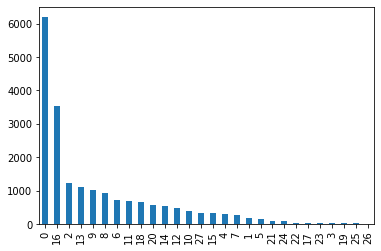

In [ ]:
weight_list = dict()
descriptions = df['description']
labels = df['label']
labels_count = labels.value_counts()
labels_count.plot(kind="bar")
print(labels.value_counts())
for index,value in labels_count.items():
    weight_list[index] = value
print(weight_list)

## Tokenization

In [ ]:
description_split = []
tkr = RegexpTokenizer('[a-zA-Z@]+')
for i, line in enumerate(descriptions):
    #print(line)
    description = str(line)
    description = tkr.tokenize(str(description))
    description_split.append(description)

print(description_split[1])

['fabhomedecor', 'fabric', 'double', 'sofa', 'bed', 'finish', 'color', 'leatherette', 'black', 'mechanism', 'type', 'pull', 'price', 'rs', 'fine', 'deep', 'seating', 'experience', 'save', 'space', 'new', 'click', 'clack', 'sofa', 'bed', 'easy', 'fold', 'vice', 'versa', 'simple', 'click', 'clack', 'mechanism', 'chrome', 'leg', 'mango', 'wood', 'frame', 'long', 'term', 'durability', 'double', 'cushioned', 'sofa', 'bed', 'provide', 'extra', 'softness', 'make', 'fine', 'seating', 'experience', 'double', 'bed', 'easily', 'sleep', 'twospecification', 'fabhomedecor', 'fabric', 'double', 'sofa', 'bed', 'finish', 'color', 'leatherette', 'black', 'mechanism', 'type', 'pull', 'installation', 'demo', 'installation', 'demo', 'detail', 'installation', 'demo', 'product', 'do', 'free', 'cost', 'part', 'purchase', 'service', 'partner', 'visit', 'location', 'within', 'business', 'hour', 'delivery', 'product', 'box', 'sofa', 'bed', 'general', 'brand', 'fabhomedecor', 'mattress', 'include', 'delivery', 'c

## Loading Word2vec model

In [ ]:
w2vModel = word2vec.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True, limit=100000)


## Building the Model 

The layers are the same as in the basic model, but we have updated the loss function. 

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(description_split)
X = tokenizer.texts_to_sequences(description_split)

#lenght of tweet to consider
MAX_LENGTH = 300
#add padding
X = pad_sequences(X, maxlen=MAX_LENGTH)
print(X.shape)

#create a embedding layer using Google pre triained word2vec (50000 words)
embedding_layer = Embedding(input_dim=w2vModel.syn0.shape[0], output_dim=w2vModel.syn0.shape[1], weights=[w2vModel.syn0], 
                            input_length=X.shape[1])

#create model


model = Sequential()
model.add(embedding_layer)
model.add(LSTM(units=300))
model.add(Dense(28, activation='softmax'))
model.compile(loss='SparseCategoricalCrossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

(19998, 300)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  if sys.path[0] == '':


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 300)          30000000  
_________________________________________________________________
lstm (LSTM)                  (None, 300)               721200    
_________________________________________________________________
dense (Dense)                (None, 28)                8428      
Total params: 30,729,628
Trainable params: 30,729,628
Non-trainable params: 0
_________________________________________________________________
None


## Train-Test-Validtion Split

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, labels, test_size= 0.1, random_state = 24)
X_val, X_test, Y_val, Y_test = train_test_split(X_test,Y_test,test_size = 0.5, random_state = 24)

X_val.shape

(1000, 300)

## Training the model 

In [ ]:
batch_size = 32
checkpoint_filepath = 'model_LSTM2.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
model.fit(X_train, Y_train, epochs=10, verbose=1, batch_size=batch_size,callbacks = [model_checkpoint_callback],validation_data = (X_val,Y_val),class_weight = weight_list)

Epoch 1/10
563/563 [==============================] - 263s 413ms/step - loss: 1913.7099 - accuracy: 0.5159 - val_loss: 0.6504 - val_accuracy: 0.8510
Epoch 2/10
563/563 [==============================] - 230s 409ms/step - loss: 284.1543 - accuracy: 0.8414 - val_loss: 0.5031 - val_accuracy: 0.8870
Epoch 3/10
563/563 [==============================] - 225s 400ms/step - loss: 133.7266 - accuracy: 0.9101 - val_loss: 0.3047 - val_accuracy: 0.9270
Epoch 4/10
563/563 [==============================] - 221s 393ms/step - loss: 88.4596 - accuracy: 0.9365 - val_loss: 0.2652 - val_accuracy: 0.9410
Epoch 5/10
563/563 [==============================] - 222s 395ms/step - loss: 48.4492 - accuracy: 0.9560 - val_loss: 0.2809 - val_accuracy: 0.9270
Epoch 6/10
563/563 [==============================] - 222s 394ms/step - loss: 43.0394 - accuracy: 0.9668 - val_loss: 0.3046 - val_accuracy: 0.9260
Epoch 7/10
563/563 [==============================] - 222s 394ms/step - loss: 36.9241 - accuracy: 0.9706 - val_los

In [ ]:

model.load_weights('model_LSTM2.h5')
score, acc = model.evaluate(X_test, Y_test, verbose = 1, batch_size=batch_size)
y_pred = np.argmax(model.predict(X_test),axis=1)

32/32 [==============================] - 1s 36ms/step - loss: 0.2876 - accuracy: 0.9400


## Performanc Evaluation
We have used Accuracy, Precision. Recall and F1 Score. <br>
We can see that the performance has improved by using the Weighted Loss Function. 

In [ ]:
class_names = ['clothing', 'furniture', 'footwear', 'pet supplies', 'pens & stationery', 'sports & fitness', 'beauty and personal care', 'bags, wallets & belts', 'home decor & festive needs', 'automotive', 'tools & hardware', 'home furnishing', 'baby care', 'mobiles & accessories', 'watches', 'toys & school supplies', 'jewellery', 'sunglasses', 'kitchen & dining', 'home & kitchen', 'computers', 'cameras & accessories', 'health & personal care appliances', 'gaming', 'home improvement', 'others']
print(len(class_names))
print(classification_report(Y_test, y_pred, target_names=class_names))

26
                                   precision    recall  f1-score   support

                         clothing       0.96      0.99      0.98       290
                        furniture       0.75      0.86      0.80         7
                         footwear       1.00      0.98      0.99        59
                     pet supplies       0.00      0.00      0.00         1
                pens & stationery       0.67      0.60      0.63        10
                 sports & fitness       0.75      0.75      0.75         8
         beauty and personal care       0.95      0.95      0.95        38
            bags, wallets & belts       0.89      0.80      0.84        10
       home decor & festive needs       0.91      0.93      0.92        43
                       automotive       0.93      0.98      0.95        43
                 tools & hardware       1.00      0.96      0.98        27
                  home furnishing       0.97      0.93      0.95        30
                     

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
